<a href="https://colab.research.google.com/github/ilmaaliyaf/learn-deep-learning/blob/main/P3_10117019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum 3
> Dikumpulkan 26 Februari 2021

> Ilma Aliya Fiddien (10117019)

### Mengimpor modul yang dibutuhkan

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn.datasets as sds

### Menggenerasi Dataset
Fungsi diberikan di praktikum

In [ ]:
class PlanarDataset(object):
    def __init__(self, points_per_class):
        self.N = points_per_class

    def load_dataset(self, shape):
        X, Y = getattr(self, "get_"+shape)()
        X, Y = X.T, np.expand_dims(Y, 0)
        return X, Y
        
    def get_circles(self):
        return sds.make_circles(n_samples=self.N, factor=.5, noise=.3)

    def get_moons(self):      
        return sds.make_moons(n_samples=self.N, noise=.2)

    def get_blobs(self):
        X, Y = sds.make_blobs(n_samples=self.N, random_state=5, n_features=2, centers=6)
        Y = Y%2
        return X, Y

    def get_quantiles(self):
        return sds.make_gaussian_quantiles(mean=None, cov=0.5, 
                                           n_samples=self.N, n_features=2, 
                                           n_classes=2, shuffle=True, 
                                           random_state=1)      

    def get_random(self):
        return np.random.rand(self.N, 2), np.random.randint(2, size=self.N)

    def get_plain(self):
        X, Y = sds.make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                       n_informative=2, random_state=1, 
                                       n_clusters_per_class=1)
        rng = np.random.RandomState(2)
        X += 2 * rng.uniform(size=X.shape)
        return X, Y

    def get_flower(self):
        m = int(self.N / 2.)
        X = np.zeros((self.N,2)) 
        Y = np.zeros(self.N, dtype='uint8')
        a = 4 

        for j in range(2):
            ix = range(m*j, m*(j+1))
            t = np.linspace(j*3.12, (j+1)*3.12, m) + np.random.randn(m)*0.2 # theta
            r = a * np.sin(4*t) + np.random.randn(m)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        return X, Y

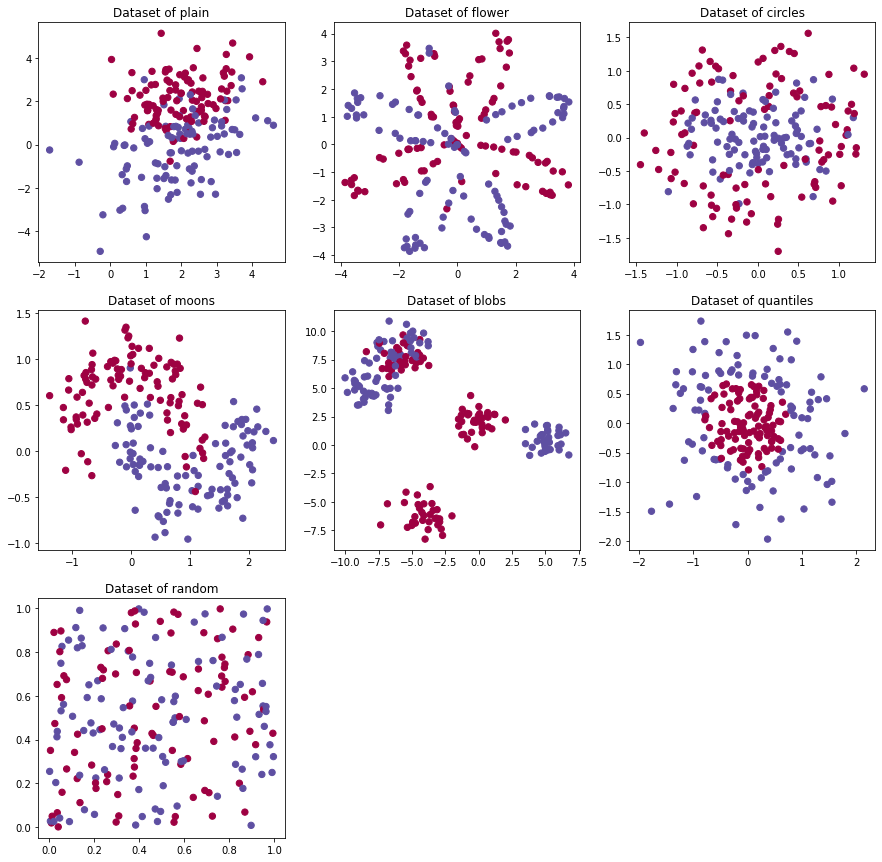

In [ ]:
dataset_lst = [
    'plain', #0
    'flower', #1
    'circles', #2
    'moons', #3
    'blobs', #4
    'quantiles', #5 
    'random' #6
]
loader = PlanarDataset(200)
plt.figure(figsize=(15, 15))
DataSet = {}
for i, shape in enumerate(dataset_lst):
    plt.subplot(3, 3, i+1)
    plt.title("Dataset of "+shape)
    X, Y = loader.load_dataset(shape)
    DataSet[shape] = (X, Y)
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

### Fungsi Pendukung

In [ ]:
def plot_decision_boundary(model, X, y):
    """ Membuat 'batas keputusan', yakni pemisah  R2  menjadi 2 region saling lepas berdasarkan label """
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, s=10, cmap=plt.cm.Spectral)
    
def sigmoid(x):
    """ Fungsi sigmoid """
    return 1 / (1+np.exp(-x))

In [ ]:
def initialize_parameters(n_x, n_h, n_y):    
    """ inisialisasi parameter w dan b 
        n_x : ukuran vektor x | n_y : ukuran vektor y | n_h : banyak hidden layer 
    """
    w1 = np.random.randn(n_h, n_x)
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h)
    b2 = np.zeros((n_y, 1))
    
    return w1, w2, b1, b2

### Fungsi-Fungsi Pembelajaran

In [ ]:
def forward_propagation(X, w1, w2, b1, b2):
    """ melakukan perambatan maju """
    Z1 = np.dot(w1, X) + b1
    A1 = np.tanh(Z1) 
    Z2 = np.dot(w2, A1) + b2
    A2 = sigmoid(Z2)
        
    return A1, A2

def backward_propagation(A1, A2, w2, X, Y):
    """ melakukan perambatan mundur """
    m = X.shape[1]

    dZ2 = A2 - Y
    dw2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(w2.T, dZ2) * (1. - np.power(A1, 2)) # menggunakan turunan fungsi tanh
    dw1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    return dw1, dw2, db1, db2

def update_parameters(parameters, grads, learning_rate = 1.2):
    """ memperbarui parameter hasil perambatan mundur """
    w1, w2, b1, b2 = parameters
    dw1, dw2, db1, db2 = grads

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
        
    return w1, w2, b1, b2


def predict(parameters, X):    
    _, A2 = forward_propagation(X, *parameters)
    predictions = (A2 > 0.5)
    
    return predictions

### Fungsi penghitung akurasi

In [ ]:
def compute_cost(A2, Y):
    m = Y.shape[1] # number of example
    logprobs = np.multiply(np.log(A2+0.01), Y) + np.multiply(np.log(1-A2+0.01), 1-Y)
    cost = - np.sum(logprobs) / m
    return float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 

def get_accuracy(parameters, X, Y):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    print("train accuracy: {} %".format(accuracy))

### Fungsi utama

In [ ]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        A1, A2 = forward_propagation(X, *parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(A1, A2, parameters[1], X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % (num_iterations // 10) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

# Menerapkan Model
## Melatih model
Dipilih 3 hidden neuron

Cost after iteration 0: 0.679513
Cost after iteration 10000: 0.171104
Cost after iteration 20000: 0.170662
Cost after iteration 30000: 0.168782
Cost after iteration 40000: 0.165507
Cost after iteration 50000: 0.162545
Cost after iteration 60000: 0.160075
Cost after iteration 70000: 0.157920
Cost after iteration 80000: 0.155970
Cost after iteration 90000: 0.154198
train accuracy: 94.5 %


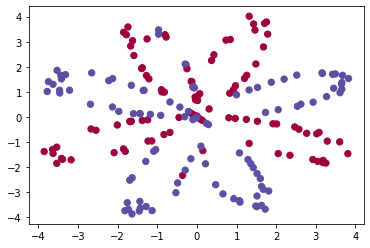

In [ ]:
hidden_neuron = 3

X, Y = DataSet["flower"]
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
parameters = nn_model(X, Y, hidden_neuron, 100000, 0.5, True)
get_accuracy(parameters, X, Y)

### Plot pembagian region

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

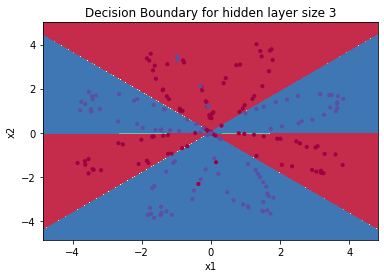

In [ ]:
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(hidden_neuron))

# Analisis Sensitivitas Banyaknya Neuron

In [ ]:
def neuron_test(shape):
    print("Dataset {}".format(shape.upper()))

    X, Y = DataSet[shape]
    plt.figure(figsize=(16, 8))
    hidden_layer_sizes = np.arange(1, 51)
    accuracy = []
    
    for n_h in hidden_layer_sizes:
        
        parameters = nn_model(X, Y, n_h, num_iterations = 1000, learning_rate = .5)
        predictions = predict(parameters, X)
        acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
        accuracy.append(acc)

        if (n_h-1)%5 == 0:
            print ("Akurasi untuk {} hidden neuron: {:.2f} %".format(n_h, acc))
            plt.subplot(2, 5, int((n_h-1)/5+1))
            plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
            plt.title('Banyak hidden neuron: %d' % n_h)
        
    plt.pause(0.05)
    plt.title('Plot banyak neuron terhadap akurasi')
    plt.plot(hidden_layer_sizes, accuracy)

    idx_max = max(range(len(accuracy)), key=accuracy.__getitem__)
    acc_max = max(accuracy)
    print('\nBanyak hidden neuron dengan akurasi tertinggi: {} ({:.2f}%)'.format(idx_max+1, acc_max))
    
    return accuracy

In [ ]:
print(DataSet.keys())
# np.random.seed(20210226)

dict_keys(['plain', 'flower', 'circles', 'moons', 'blobs', 'quantiles', 'random'])


True

## Dataset PLAIN


Dataset PLAIN
Akurasi untuk 1 hidden neuron: 82.00 %
Akurasi untuk 6 hidden neuron: 87.50 %
Akurasi untuk 11 hidden neuron: 87.00 %
Akurasi untuk 16 hidden neuron: 86.50 %
Akurasi untuk 21 hidden neuron: 87.00 %
Akurasi untuk 26 hidden neuron: 86.00 %
Akurasi untuk 31 hidden neuron: 86.00 %
Akurasi untuk 36 hidden neuron: 86.50 %
Akurasi untuk 41 hidden neuron: 87.00 %
Akurasi untuk 46 hidden neuron: 86.00 %


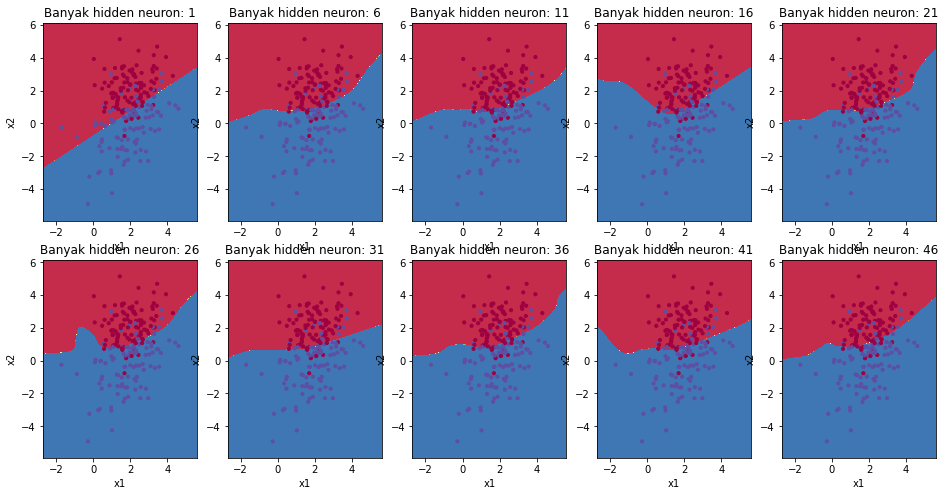


Banyak hidden neuron dengan akurasi tertinggi: 3 (87.50%)


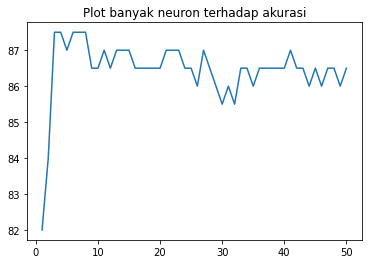

In [ ]:
plain_accuracy = neuron_test("plain")

### Analisis
> Terlihat bahwa jika kode di atas dieksekusi beberapa kali, akurasi tertinggi didapat oleh SNN dengan *hidden neuron* yang sedikit (<10).
> Karena kecenderungan klasifikasi data set ini, sulit untuk menentukan bentuk yang cukup terstruktur pada model prediksi klasifikasi yang dibuat. Akibatnya, tidak terlihat perbaikan yang berarti jika banyaknya hidden neuron ditambah.

## Dataset FLOWER

Dataset FLOWER
Akurasi untuk 1 hidden neuron: 70.00 %
Akurasi untuk 6 hidden neuron: 93.50 %
Akurasi untuk 11 hidden neuron: 93.00 %
Akurasi untuk 16 hidden neuron: 92.50 %
Akurasi untuk 21 hidden neuron: 93.00 %
Akurasi untuk 26 hidden neuron: 93.50 %
Akurasi untuk 31 hidden neuron: 93.50 %
Akurasi untuk 36 hidden neuron: 93.50 %
Akurasi untuk 41 hidden neuron: 92.50 %
Akurasi untuk 46 hidden neuron: 93.00 %


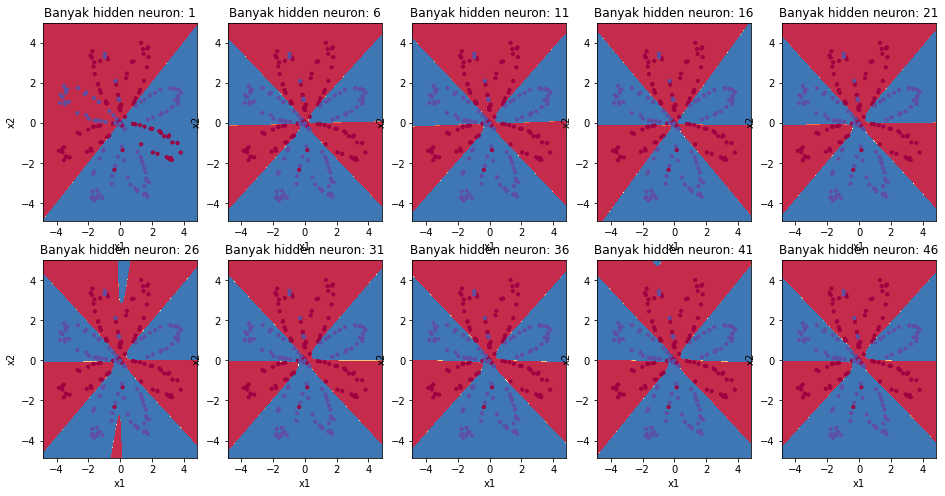


Banyak hidden neuron dengan akurasi tertinggi: 4 (94.00%)


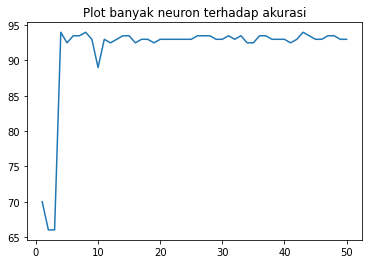

In [ ]:
flower_accuracy = neuron_test("flower")

### Analisis
> Karena pemetaan klasifikasi data set FLOWER ini mengikuti suatu struktur yang cukup rapi, kita bisa menebak berapa minimal banyak *hidden neuron* yang dibutuhkan untuk mendapatkan akurasi prediksi yang bagus.

> FLOWER di sini memiliki 8 kelopak, dengan titik-titik di satu kelopak cenderung memiliki klasifikasi yang sama. Dibutuhkan 4 garis untuk membagi region ke dalam 8 bagian, andaikan setiap kelopak bersebelahan memiliki warna berbeda. Oleh karena itu, banyak hidden neuron yang lebih dari 4 akan memberikan hasil prediksi yang lebih baik. Hidden neuron tambahannya digunakan untuk mengakomodasi titik-titik yang tidak mengikuti pola klasifikasi titik-titik di kelopak (pencilan).

> Jadi, untuk dataset FLOWER, semakin banyak *hidden neuron* maka semakin akurasi model.

In [ ]:
for idx,val in enumerate(flower_accuracy[1:7]):
    print('Akurasi {} hidden neuron: {}%'.format(idx+1, val))

Akurasi 1 hidden neuron: 66.0%
Akurasi 2 hidden neuron: 66.0%
Akurasi 3 hidden neuron: 94.0%
Akurasi 4 hidden neuron: 92.5%
Akurasi 5 hidden neuron: 93.5%
Akurasi 6 hidden neuron: 93.5%


## Dataset CIRCLES

Dataset CIRCLES
Akurasi untuk 1 hidden neuron: 51.50 %
Akurasi untuk 6 hidden neuron: 51.50 %
Akurasi untuk 11 hidden neuron: 54.00 %
Akurasi untuk 16 hidden neuron: 58.00 %
Akurasi untuk 21 hidden neuron: 59.00 %
Akurasi untuk 26 hidden neuron: 60.00 %
Akurasi untuk 31 hidden neuron: 85.50 %
Akurasi untuk 36 hidden neuron: 61.00 %
Akurasi untuk 41 hidden neuron: 62.50 %
Akurasi untuk 46 hidden neuron: 83.00 %


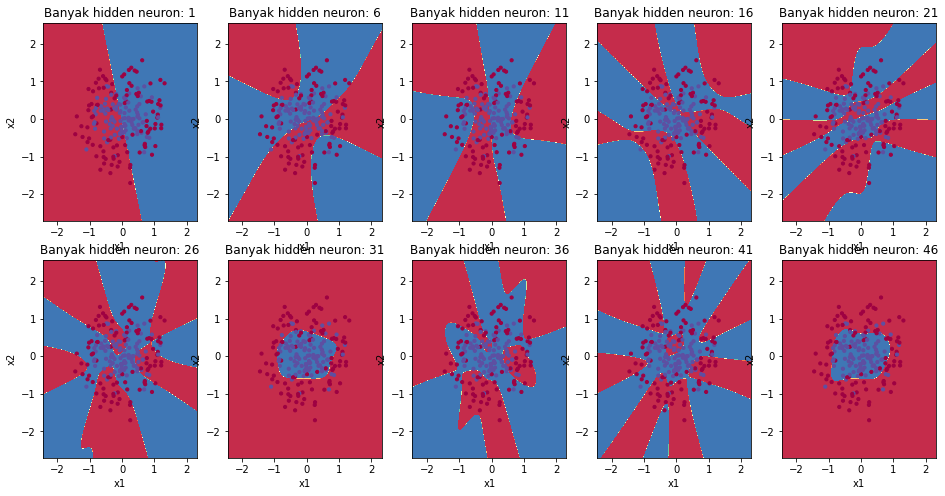


Banyak hidden neuron dengan akurasi tertinggi: 31 (85.50%)


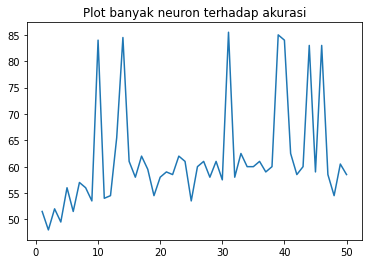

In [ ]:
circles_accuracy = neuron_test("circles")

### Analisis
> Semakin banyak *hidden neuran*, semakin bagus bentuk region prediksi klasifikasi yang dibuat, yaitu terdapat lingkaran di tengah bidang.

> Akurasi yang tinggi cenderung sporadis. 

In [ ]:
high_acc = np.array(circles_accuracy)>80
print(high_acc)

for i,acc in enumerate(high_acc):
    if acc:
        print(i+1, end=" ")

[False False False False False False False False False  True False False
 False  True False False False False False False False False False False
 False False False False False False  True False False False False False
 False False  True  True False False False  True False  True False False
 False False]
10 14 31 39 40 44 46 

## Dataset MOONS

Dataset MOONS
Akurasi untuk 1 hidden neuron: 80.00 %
Akurasi untuk 6 hidden neuron: 90.00 %
Akurasi untuk 11 hidden neuron: 91.50 %
Akurasi untuk 16 hidden neuron: 91.50 %
Akurasi untuk 21 hidden neuron: 91.50 %
Akurasi untuk 26 hidden neuron: 92.50 %
Akurasi untuk 31 hidden neuron: 90.50 %
Akurasi untuk 36 hidden neuron: 93.00 %
Akurasi untuk 41 hidden neuron: 90.50 %
Akurasi untuk 46 hidden neuron: 91.50 %


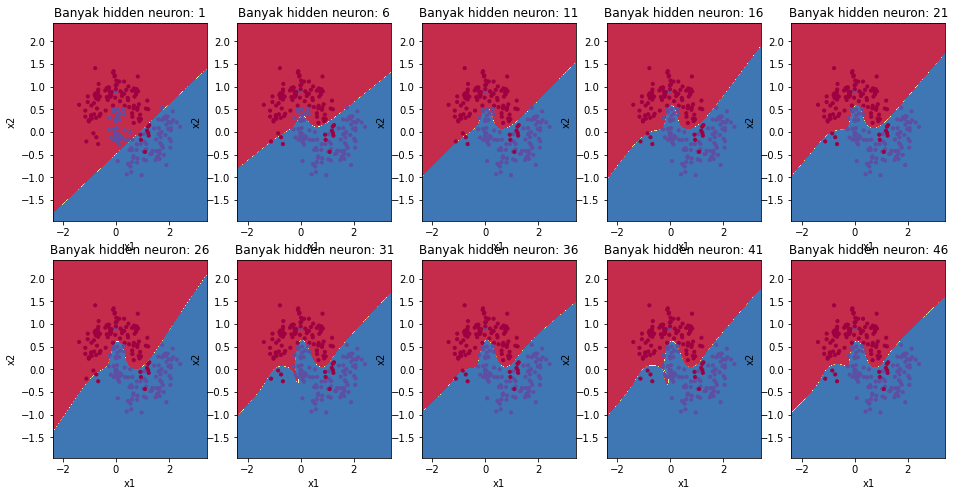


Banyak hidden neuron dengan akurasi tertinggi: 40 (97.50%)


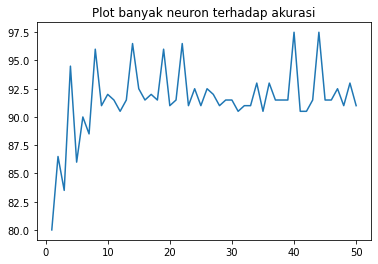

In [ ]:
moons_accuracy = neuron_test("moons")

### Analisis
> Dalam menambah *hidden neuron*, tidak terdapat pola kenaikan akurasi yang berarti.

> Akurasi yang tinggi cenderung didapat jika model memiliki lebih dari 4 neuron.

In [ ]:
high_acc = np.array(moons_accuracy)>93
print(high_acc)

for i,acc in enumerate(high_acc):
    if acc:
        print(i+1, end=" ")

[False False False  True False False False  True False False False False
 False  True False False False False  True False False  True False False
 False False False False False False False False False False False False
 False False False  True False False False  True False False False False
 False False]
4 8 14 19 22 40 44 

## Dataset BLOBS

Dataset BLOBS
Akurasi untuk 1 hidden neuron: 66.50 %
Akurasi untuk 6 hidden neuron: 85.00 %
Akurasi untuk 11 hidden neuron: 85.00 %
Akurasi untuk 16 hidden neuron: 87.00 %
Akurasi untuk 21 hidden neuron: 85.50 %
Akurasi untuk 26 hidden neuron: 83.50 %
Akurasi untuk 31 hidden neuron: 84.00 %
Akurasi untuk 36 hidden neuron: 86.50 %
Akurasi untuk 41 hidden neuron: 83.00 %
Akurasi untuk 46 hidden neuron: 85.00 %


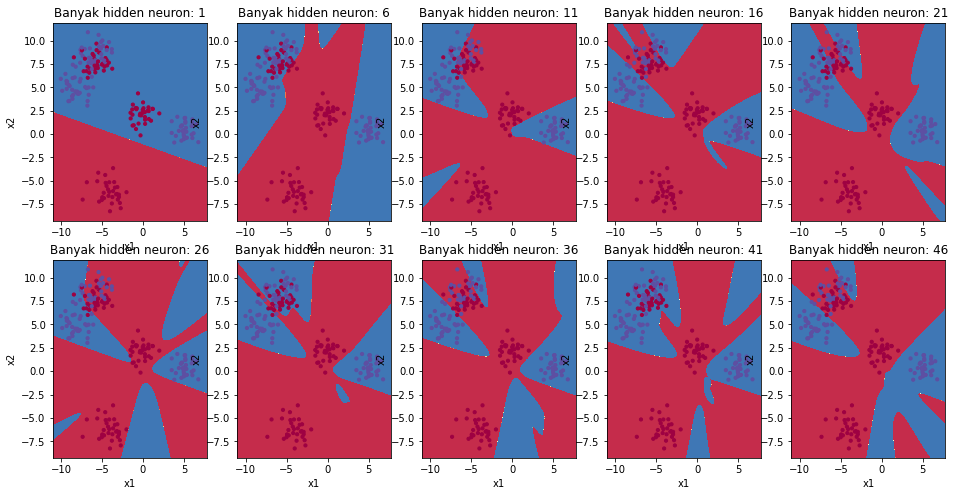


Banyak hidden neuron dengan akurasi tertinggi: 12 (88.50%)


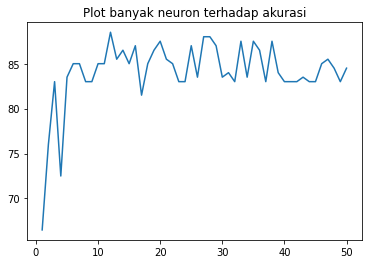

In [ ]:
blobs_accuracy = neuron_test("blobs")

### Analisis
> Dalam penambahan *hidden neuron*, tidak ada perbaikan akurasi yang cukup bagus, kecuali di sekitar 5-9.

## Dataset QUANTILES

Dataset QUANTILES
Akurasi untuk 1 hidden neuron: 55.00 %
Akurasi untuk 6 hidden neuron: 63.50 %
Akurasi untuk 11 hidden neuron: 98.50 %
Akurasi untuk 16 hidden neuron: 63.50 %
Akurasi untuk 21 hidden neuron: 61.00 %
Akurasi untuk 26 hidden neuron: 99.50 %
Akurasi untuk 31 hidden neuron: 60.50 %
Akurasi untuk 36 hidden neuron: 99.00 %
Akurasi untuk 41 hidden neuron: 61.00 %
Akurasi untuk 46 hidden neuron: 62.00 %


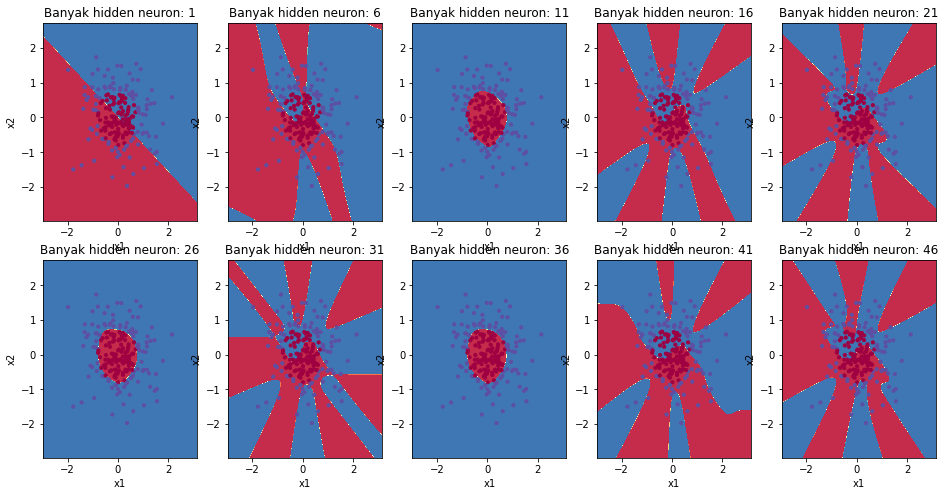


Banyak hidden neuron dengan akurasi tertinggi: 26 (99.50%)


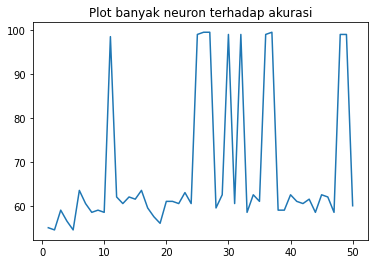

In [ ]:
quantiles_accuracy = neuron_test("quantiles")

### Analisis
> Terdapat perbandingan gap akurasi yang sangat timpang. Akurasi batas-batas prediksi klasifikasi membentuk lingkaran.

## Dataset RANDOM

Dataset RANDOM
Akurasi untuk 1 hidden neuron: 53.00 %
Akurasi untuk 6 hidden neuron: 55.50 %
Akurasi untuk 11 hidden neuron: 53.50 %
Akurasi untuk 16 hidden neuron: 56.00 %
Akurasi untuk 21 hidden neuron: 55.00 %
Akurasi untuk 26 hidden neuron: 52.50 %
Akurasi untuk 31 hidden neuron: 56.00 %
Akurasi untuk 36 hidden neuron: 52.00 %
Akurasi untuk 41 hidden neuron: 53.00 %
Akurasi untuk 46 hidden neuron: 51.50 %


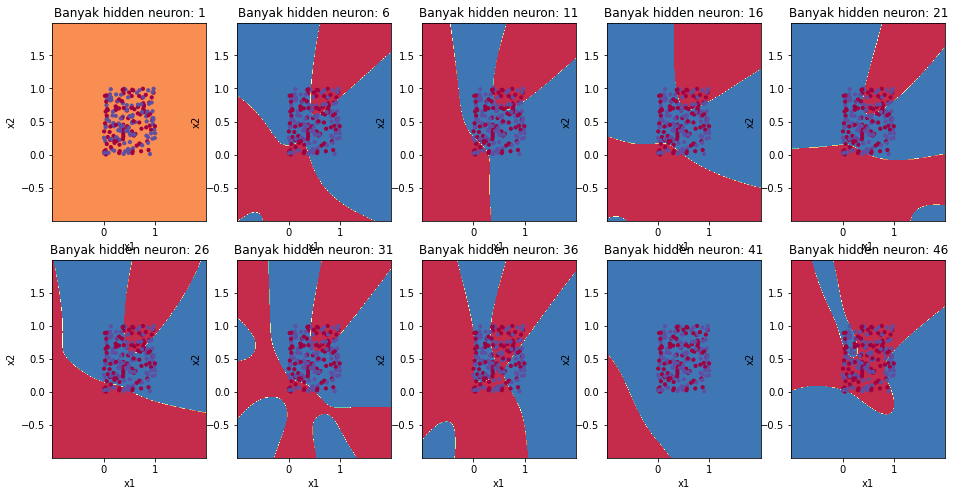


Banyak hidden neuron dengan akurasi tertinggi: 22 (57.50%)


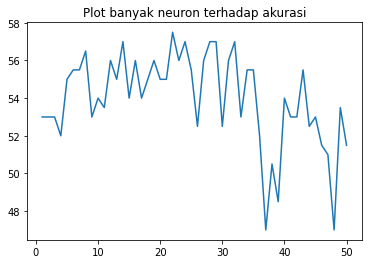

In [ ]:
random_accuracy = neuron_test("random")

### Analisis
> Karena bentuk datanya random, maka tidak ada gambaran seberapa banyak *hidden neuron* yang dibutuhkan untuk mendapat prediksi yang bagus.